# TL;DR
- Le dataset contient 212322 observation dont 791 (<1%) n'a aucune anomalie de renseignée (i.e NaN)

- Un regex a été utilisé pour parcourir les anomalies afin de les assigner à l'une des 14 catégories de la taxonomie. Pour 9537 observations, c-a-d 8745 effective hors NaN les anomalies renseignées ne correspondent pas ou ne contiennent pas les labels de la taxonomie. # TODO: Ces observations seront mis à part et ne seront pas utilisé pour l'entrainement dans un premier temps.
- La partie des données correctement annotés a été divisé en 3 : Train, Validation, Test dont la proportion des classes est représentative de la population initiales d'observations.
- Le dataset est fortement déséquilibre entre les classes

In [117]:
import json
import re
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_parquet("../data/01_primary/asrs_data_primary.parquet")

In [3]:
with open("../data/01_primary/taxonomy.json", "r") as f:
    taxonomy = json.load(f)

In [4]:
categories = [cat for cat in taxonomy.keys() if cat not in ["Other", "ATC Issues"]] + [
    "ATC Issue"
]
escaped_categories = escaped_terms = [
    re.escape(term.strip().replace(" / ", "/")) for term in categories
]
pattern = re.compile(r"(" + "|".join(escaped_categories) + r")")

In [6]:
def get_category(text: "str", pattern: "re.Pattern"):
    if text is not None:
        return " ; ".join(list(set(pattern.findall(text.strip().replace(" / ", "/")))))

In [7]:
df1a = df1[["acn", "narrative", "anomaly"]]

In [8]:
df1a["anomaly"] = df1.anomaly.apply(lambda t: get_category(text=t, pattern=pattern))

/var/folders/w4/pt773y8s3b736sz4g0jqyc180000gn/T/ipykernel_43775/2310314930.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1a["anomaly"] = df1.anomaly.apply(lambda t: get_category(text=t, pattern=pattern))


In [22]:
occurences = []
none_counter = 0
for item in df1a["anomaly"].to_list():
    if item is not None:
        occurences.extend([term.strip() for term in item.split(";")])
    else:
        none_counter += 1

In [23]:
counter = Counter(occurences)

In [24]:
counter

Counter({'Deviation/Discrepancy - Procedural': 129195,
         'Aircraft Equipment': 69177,
         'Conflict': 43390,
         'Inflight Event/Encounter': 32478,
         'Deviation - Altitude': 26777,
         'ATC Issue': 26576,
         'Deviation - Track/Heading': 20037,
         'Ground Incursion': 11537,
         'Airspace Violation': 10550,
         'Flight Deck/Cabin/Aircraft Event': 10278,
         'Ground Event/Encounter': 10040,
         '': 9537,
         'Deviation - Speed': 4310,
         'Ground Excursion': 2786,
         'No Specific Anomaly Occurred': 1433})

In [25]:
none_counter

791

In [ ]:
def get_category(text: "str", pattern: "re.Pattern"):
    if text is not None:
        return " ; ".join(list(set(pattern.findall(text.strip().replace(" / ", "/")))))

In [46]:
one_hot_mapping = dict(zip(sorted(categories), range(0, 14)))
one_hot_mapping = {
    k.strip().replace(" / ", "/"): v for (k, v) in one_hot_mapping.items()
}
with open("../data/01_primary/one_hot_mapping.json", "w") as f:
    json.dump(one_hot_mapping, f, indent=4)

In [47]:
one_hot_mapping

{'ATC Issue': 0,
 'Aircraft Equipment': 1,
 'Airspace Violation': 2,
 'Conflict': 3,
 'Deviation - Altitude': 4,
 'Deviation - Speed': 5,
 'Deviation - Track/Heading': 6,
 'Deviation/Discrepancy - Procedural': 7,
 'Flight Deck/Cabin/Aircraft Event': 8,
 'Ground Event/Encounter': 9,
 'Ground Excursion': 10,
 'Ground Incursion': 11,
 'Inflight Event/Encounter': 12,
 'No Specific Anomaly Occurred': 13}

In [52]:
df1a = df1a.dropna(axis=0, how="any")

In [81]:
df1b = df1a.loc[df1a["anomaly"] != ""]
df1c = df1a.loc[df1a["anomaly"] == ""]

In [96]:
df1b.head()

,acn,narrative,anomaly
0,1299097,The flight came over descending to FL240 flyin...,Deviation - Altitude ; Deviation/Discrepancy -...
1,1299098,I was sequencing multiple arrivals to ZZZ; 2 r...,Conflict ; Deviation/Discrepancy - Procedural ...
2,1299106,An aircraft entered New York's non-radar airsp...,Deviation/Discrepancy - Procedural ; Airspace ...
3,1299250,We were cruising at FL360; in cirrus type clou...,Deviation - Altitude ; Deviation/Discrepancy -...
4,1299290,Bird strike at approximately 300-400 AGL durin...,Inflight Event/Encounter ; Aircraft Equipment


In [ ]:
df1b_train, df1b_eval = train_test_split(df1b, test_size=0.4, random_state=4294967295)
df1b_validation, df1b_test = train_test_split(
    df1b_eval, test_size=0.5, random_state=4294967295
)

In [92]:
df1b_train.to_parquet("../data/asrs_data_primary_train.parquet")
df1b_validation.to_parquet("../data/asrs_data_primary_validation.parquet")
df1b_test.to_parquet("../data/asrs_data_primary_test.parquet")
df1c.to_parquet("../data/asrs_data_primary_others.parquet")

In [106]:
def get_occurences(df: "pd.Dataframe"):
    occurences = []
    for item in df["anomaly"].to_list():
        if item is not None:
            occurences.extend([term.strip() for term in item.split(";")])
    counter = Counter(occurences)
    return counter

In [107]:
df1b_counter = get_occurences(df=df1b)
train_counter = get_occurences(df=df1b_train)
val_counter = get_occurences(df=df1b_validation)
test_counter = get_occurences(df=df1b_test)

In [119]:
df1b_counter

Counter({'Deviation/Discrepancy - Procedural': 129195,
         'Aircraft Equipment': 69177,
         'Conflict': 43390,
         'Inflight Event/Encounter': 32478,
         'Deviation - Altitude': 26777,
         'ATC Issue': 26576,
         'Deviation - Track/Heading': 20037,
         'Ground Incursion': 11537,
         'Airspace Violation': 10550,
         'Flight Deck/Cabin/Aircraft Event': 10278,
         'Ground Event/Encounter': 10040,
         'Deviation - Speed': 4310,
         'Ground Excursion': 2786,
         'No Specific Anomaly Occurred': 1433})

In [128]:
counters = zip(
    [df1b_counter, train_counter, val_counter, test_counter],
    ["Total", "Train", "Validation", "Test"],
)
data = [
    pd.DataFrame(
        {
            "anomaly": counter.keys(),
            "count": counter.values(),
            "split": [name] * len(counter),
        }
    )
    for (counter, name) in counters
]
data = pd.concat(data).reset_index()

In [133]:
data.head()

,index,anomaly,count,split
0,0,Deviation - Altitude,26777,Total
1,1,Deviation/Discrepancy - Procedural,129195,Total
2,2,Conflict,43390,Total
3,3,Deviation - Track/Heading,20037,Total
4,4,Deviation - Speed,4310,Total


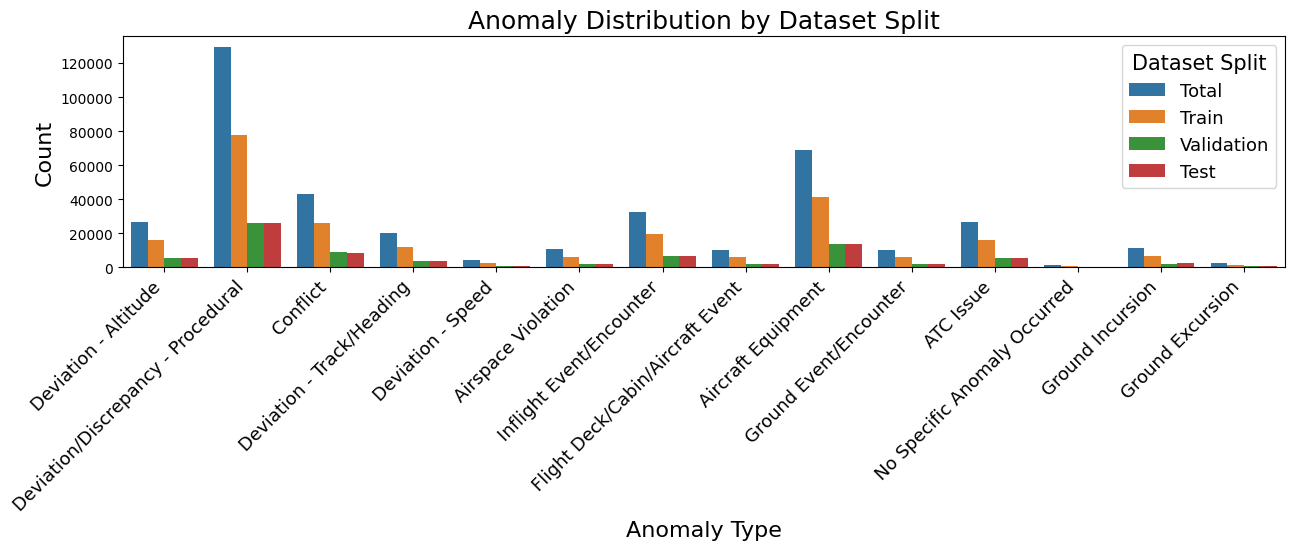

In [155]:
plt.figure(figsize=(15, 3))
sns.barplot(data=data, hue="split", x="anomaly", y="count")
plt.xticks(rotation=45, ha="right", fontsize=13)  # or try 90 for vertical
plt.xlabel("Anomaly Type", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Anomaly Distribution by Dataset Split", fontsize=18)
plt.legend(title="Dataset Split", title_fontsize=15, fontsize=13)
plt.show()